In [1]:
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [3]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, padding_ids):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=padding_ids, max_norm=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        input: x (batch, seq_len)
        output: embeddings of x (batch, seq_len, embed_dim)
        """
        return self.embedding(x)

In [4]:
embd = Embedding(vocab_size=10000, embed_dim=512, padding_ids=0)
emb_enc = embd(torch.randint(0, 10000, size=(32, 90)))
emb_enc.shape

torch.Size([32, 90, 512])

In [5]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, ndim):
        super().__init__()
        self.ndim = ndim

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        input: x (batch, seq_len)
        output: positional encoding of x (batch, seq_len, ndim)
        """
        batch_size, seq_len = x.shape

        pos = torch.arange(seq_len, device=x.device).unsqueeze(1)
        div_term = torch.exp(-torch.arange(0, self.ndim, 2, device=x.device) * (math.log(10000.0) / self.ndim))

        encodings = torch.zeros(batch_size, seq_len, self.ndim, device=x.device)
        encodings[:, :, 0::2] = torch.sin(pos * div_term)
        encodings[:, :, 1::2] = torch.cos(pos * div_term)

        return encodings

In [6]:
pose = PositionalEncoding(ndim=512)

enc = pose(torch.rand(size=(32, 90)))
enc.shape

torch.Size([32, 90, 512])

### Visualizing Positional Encoding

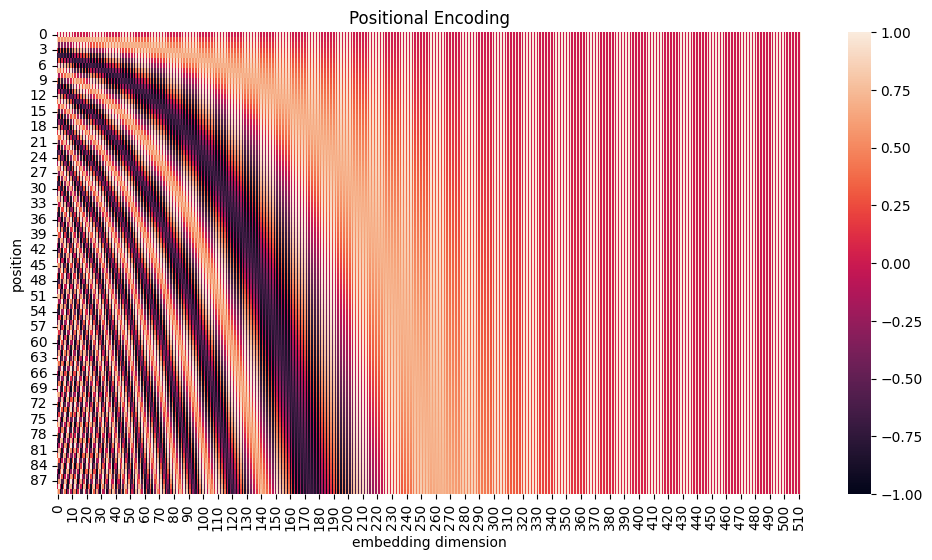

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(enc[1, :, :], cmap='rocket')

plt.title("Positional Encoding")
plt.xlabel("embedding dimension")
plt.ylabel("position")

plt.show()

In [8]:
torch.add(emb_enc, enc).shape

torch.Size([32, 90, 512])

### Attention function

In [9]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, d_k, d_v):
        super().__init__()
        self.d_k = float(d_k)
        self.W_Q = nn.Linear(in_features=hidden_dim, out_features=d_k)
        self.W_K = nn.Linear(in_features=hidden_dim, out_features=d_k)
        self.W_V = nn.Linear(in_features=hidden_dim, out_features=d_v)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        input: x (batch, seq_len, hidden dim)
        output: attention weights (batch, seq_len, d_v)
        """
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        scores = torch.matmul(Q, K.transpose(1, 2)) / self.d_k**0.5
        
        mask = torch.triu(input=torch.ones_like(scores), diagonal=1).to(device=device)
        mask = mask.masked_fill(mask==1, value=-float('inf')).masked_fill(mask==0, value=0)

        scores += mask
        attn_weights = torch.softmax(scores, dim=-1)

        return torch.matmul(attn_weights, V)

In [10]:
attn = Attention(hidden_dim=512, d_k=64, d_v=64)
attn.to(device=device)

at = attn(torch.rand(size=(32, 90, 512), device=device))
at.shape

torch.Size([32, 90, 64])

### Multihead Attention

All heads are computed in parallel, where inside each head calculations for all sequences is performed at parallel

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, hidden_dim, d_k, d_v):
        super().__init__()
        self.d_k = float(d_k)
        self.heads = heads

        embedding_dim_key = d_k*heads
        embedding_dim_value = d_v*heads

        self.W_Q = nn.Linear(in_features=hidden_dim, out_features=embedding_dim_key)
        self.W_K = nn.Linear(in_features=hidden_dim, out_features=embedding_dim_key)
        self.W_V = nn.Linear(in_features=hidden_dim, out_features=embedding_dim_value)
        self.W_0 = nn.Linear(in_features=heads*d_v, out_features=hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        input: x (batch, seq_len, hidden dim)
        """
        batch_size, seq_len, hidden_dim = x.shape

        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        Q = Q.view(batch_size, self.heads, seq_len, -1)
        K = K.view(batch_size, self.heads, seq_len, -1)
        V = V.view(batch_size, self.heads, seq_len, -1)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.d_k**0.5
        
        mask = torch.triu(input=torch.ones_like(scores), diagonal=1).to(device=device)
        mask = mask.masked_fill(mask==1, value=-float('inf')).masked_fill(mask==0, value=0)

        scores += mask
        attn_weights = torch.softmax(scores, dim=-1)

        multihead_output = torch.matmul(attn_weights, V)

        multihead = multihead_output.transpose(1, 2).contiguous().view(batch_size, seq_len, -1)
        # contiguous stores elements in sequential manner without any gaps

        output = self.W_0(multihead)

        return output
    

attn = MultiHeadAttention(heads=8, hidden_dim=512, d_k=64, d_v=64)
attn.to(device=device)

at = attn(torch.rand(size=(32, 90, 512), device=device))
at.shape

torch.Size([32, 90, 512])

Now our multihead attention is complete. This was an important part.


Next, let's move to calculation of **LayerNorm** and **Feed Forward Layers**


### LayerNorm

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, hidden_dim, epsilon):
        """
        gamma and beta are learnable parameters
        initialization:
        - gamma: ones
        - beta: zeros

        shape: hidden_dim
        """
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_dim))
        self.beta = nn.Parameter(torch.zeros(hidden_dim))
        # nn.Parameter defines learnable params
        self.epsilon = epsilon

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mean = x.mean(dim=2, keepdim=True)
        std = x.std(dim=2, keepdim=True)

        x_norm = (x - mean)/(std + self.epsilon)
        return self.gamma*x_norm + self.beta
    
lyr_norm = LayerNorm(hidden_dim=512, epsilon=1e-5)
lyr_norm.to(device=device)
lrn = lyr_norm(at)

lrn.shape

torch.Size([32, 90, 512])

### Feed Forward Layer

In [13]:
class FFN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=hidden_size, out_features=input_size)
        )

    def forward(self, x):
        return self.layers(x)
    

ffn = FFN(input_size=512, hidden_size=2048, dropout=0.1)
ffn.to(device=device)

fo = ffn(lrn)

fo.shape

torch.Size([32, 90, 512])

In [14]:
class ResidualConnection(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x1, x2):
        return x1+ x2
    
residual = ResidualConnection()
res = residual(fo, at)
res.shape

torch.Size([32, 90, 512])

## Building Encoder block by combining all

In [15]:
class EncoderLayers(nn.Module):
    def __init__(self, embed_dim, d_k, d_v, encoder_heads, epsilon):
        super().__init__()

        self.multihead_attention = MultiHeadAttention(heads=encoder_heads, hidden_dim=embed_dim, d_k=d_k, d_v=d_v)
        self.residual1 = ResidualConnection()
        self.residual2 = ResidualConnection()
        self.layer_norm1 = LayerNorm(hidden_dim=embed_dim, epsilon=epsilon)
        self.layer_norm2 = LayerNorm(hidden_dim=embed_dim, epsilon=epsilon)
        self.ffn = FFN(input_size=embed_dim, hidden_size=4*embed_dim, dropout=0.2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.multihead_attention(x)
        x2 = self.residual1(x, x1)
        x2 = self.layer_norm1(x2)

        ffn = self.ffn(x2)
        x3 = self.residual2(x2, ffn)
        x3 = self.layer_norm2(x3)

        return x3

In [31]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, padding_ids, encoder_heads, num_layers, epsilon):
        super().__init__()
        
        self.input_embedding = Embedding(vocab_size=vocab_size, embed_dim=embed_dim, padding_ids=padding_ids)
        self.pos_encoding = PositionalEncoding(ndim=embed_dim)

        self.d_k = embed_dim // encoder_heads
        self.d_v = embed_dim // encoder_heads

        self.layers = nn.ModuleList([
            EncoderLayers(embed_dim=embed_dim, d_k=self.d_k, d_v=self.d_v, encoder_heads=encoder_heads, epsilon=epsilon) for i in range(num_layers)
        ])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        inpe = self.input_embedding(x)
        pose = self.pos_encoding(x)

        x = inpe + pose

        # The implementation below is wrong, because each layer should have its own parameters, and here we are updating on a single architecture
        # for head in range(self.heads):
        #     x1 = self.multihead_attention(x)
        #     x2 = self.residual_connection(x, x1)
        #     x2 = self.layer_norm(x2)
        #     ffn = self.ffn(x2)
        #     x3 = self.residual_connection(x2, ffn)
        #     x3 = self.layer_norm(x3)
        #     x = x3

        for layer in self.layers:
            x = layer(x)

        return x
    
encoder = Encoder(vocab_size=10000, embed_dim=512, padding_ids=0, encoder_heads=8, epsilon=1e-5, num_layers=6)
encoder.to(device=device)

encoder, sum(torch.numel(i) for i in encoder.parameters() if i.requires_grad), sum(torch.numel(i) for i in encoder.parameters()), next(encoder.parameters()).device

(Encoder(
   (input_embedding): Embedding(
     (embedding): Embedding(10000, 512, padding_idx=0, max_norm=1)
   )
   (pos_encoding): PositionalEncoding()
   (layers): ModuleList(
     (0-5): 6 x EncoderLayers(
       (multihead_attention): MultiHeadAttention(
         (W_Q): Linear(in_features=512, out_features=512, bias=True)
         (W_K): Linear(in_features=512, out_features=512, bias=True)
         (W_V): Linear(in_features=512, out_features=512, bias=True)
         (W_0): Linear(in_features=512, out_features=512, bias=True)
       )
       (residual1): ResidualConnection()
       (residual2): ResidualConnection()
       (layer_norm1): LayerNorm()
       (layer_norm2): LayerNorm()
       (ffn): FFN(
         (layers): Sequential(
           (0): Linear(in_features=512, out_features=2048, bias=True)
           (1): ReLU()
           (2): Dropout(p=0.2, inplace=False)
           (3): Linear(in_features=2048, out_features=512, bias=True)
         )
       )
     )
   )
 ),
 24034304

In [17]:
from torchinfo import summary

summary(model=encoder, input_data=torch.randint(0, 10000, size=(32, 90)), device=device, col_names=["input_size", "output_size", "num_params", "trainable"])

/opt/homebrew/Caskroom/miniconda/base/envs/silvercule/lib/python3.13/site-packages/torch/nn/functional.py:2434: UserWarning: The operator 'aten::embedding_renorm_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:14.)
  torch.embedding_renorm_(weight.detach(), input, max_norm, norm_type)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
Encoder                                  [32, 90]                  [32, 90, 512]             --                        True
├─Embedding: 1-1                         [32, 90]                  [32, 90, 512]             --                        True
│    └─Embedding: 2-1                    [32, 90]                  [32, 90, 512]             5,120,000                 True
├─PositionalEncoding: 1-2                [32, 90]                  [32, 90, 512]             --                        --
├─ModuleList: 1-3                        --                        --                        --                        True
│    └─EncoderLayers: 2-2                [32, 90, 512]             [32, 90, 512]             --                        True
│    │    └─MultiHeadAttention: 3-1      [32, 90, 512]             [32, 90, 512]             1,050,624                 True
│    

### Now in the original transformer paper, we pass the output from Encoder to the decoder, building cross attention layers and also we have masked self attention layer in decoder as well, alongside layernorm, residual and feed-forward connections.

Let's build these.

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, hidden_dim, d_v, d_k):
        super().__init__()

        self.d_k = float(d_k)
        self.W_Q = nn.Linear(in_features=hidden_dim, out_features=d_k)
        self.W_K = nn.Linear(in_features=hidden_dim, out_features=d_k)
        self.W_V = nn.Linear(in_features=hidden_dim, out_features=d_v)

    def forward(self, encoder_outputs: torch.Tensor, decoder_hidden: torch.Tensor) -> torch.Tensor:
        """
        encoder_outputs: (batch, seq_len, hidden_dim)
        """
        Q = self.W_Q(decoder_hidden) # (batch, seq_len, d_k)
        K = self.W_K(encoder_outputs) # (batch, seq_len, d_k)
        V = self.W_V(encoder_outputs) # (batch, seq_len, d_v)

        scores = torch.matmul(Q, K.transpose(1, 2)) / float(self.d_k)**0.5 # (batch, seq, seq)

        attention = torch.softmax(scores, dim=-1)

        return torch.matmul(attention, V)

### Cross Attention

In [22]:
class TransformerCrossAttention(nn.Module):
    def __init__(self, hidden_dim, heads, d_k, d_v):
        super().__init__()

        emb_dim_k = heads*d_k
        emb_dim_v = heads*d_v
        self.heads = heads

        self.d_k = float(d_k)

        self.W_K = nn.Linear(in_features=hidden_dim, out_features=emb_dim_k)
        self.W_Q = nn.Linear(in_features=hidden_dim, out_features=emb_dim_k)
        self.W_V = nn.Linear(in_features=hidden_dim, out_features=emb_dim_v)
        self.W_0 = nn.Linear(in_features=heads*d_v, out_features=hidden_dim)

    def forward(self, encoder_output: torch.Tensor, decoder_hidden: torch.Tensor) -> torch.Tensor:

        batch, seq_len, _ = encoder_output.shape
        batch_dec, seq_dec, _ = decoder_hidden.shape

        K = self.W_K(encoder_output)
        V = self.W_V(encoder_output) 
        Q = self.W_Q(decoder_hidden)

        K = K.view(batch, self.heads, seq_len, -1)
        V = V.view(batch, self.heads, seq_len, -1) # (batch, heads, seq_len, dv)
        Q = Q.view(batch, self.heads, seq_dec, -1)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)

        out = torch.softmax(scores, dim=-1) # (batch, heads, seq_dec, seq_len)
        attn_heads = torch.matmul(out, V) # (batch, heads, seq_dec, dv)

        attention = attn_heads.transpose(1, 2).contiguous().view(batch, seq_dec, -1)

        return self.W_0(attention)
    
crattn = TransformerCrossAttention(hidden_dim=512, heads=8, d_v=64, d_k=64)
crattn.to(device=device)

crattn

TransformerCrossAttention(
  (W_K): Linear(in_features=512, out_features=512, bias=True)
  (W_Q): Linear(in_features=512, out_features=512, bias=True)
  (W_V): Linear(in_features=512, out_features=512, bias=True)
  (W_0): Linear(in_features=512, out_features=512, bias=True)
)

In [26]:
crossotp = crattn(torch.rand(size=(32, 90, 512), device=device), torch.rand(size=(32, 110, 512), device=device))
crossotp.shape

torch.Size([32, 110, 512])

### Masked Multi head attention 

In [28]:
class MaskedSelfAttention(nn.Module):
    def __init__(self, hidden_dim, heads, d_k, d_v):
        super().__init__()

        self.heads = heads
        self.d_k = float(d_k)

        embed_dim_key = heads*d_k
        embed_dim_val = heads*d_v

        self.W_K = nn.Linear(in_features=hidden_dim, out_features=embed_dim_key)
        self.W_Q = nn.Linear(in_features=hidden_dim, out_features=embed_dim_key)
        self.W_V = nn.Linear(in_features=hidden_dim, out_features=embed_dim_val)
        self.W_0 = nn.Linear(in_features=heads*d_v, out_features=hidden_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        batch, seq_len, hidden_dim = x.shape

        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)

        Q = Q.view(batch, self.heads, seq_len, -1)
        K = K.view(batch, self.heads, seq_len, -1)
        V = V.view(batch, self.heads, seq_len, -1)

        score = torch.matmul(Q, K.transpose(-2, -1)) / (self.d_k ** 0.5)

        mask = torch.triu(torch.ones_like(score), diagonal=1)
        mask = mask.masked_fill(mask==1, -float('inf'))

        score += mask

        out = torch.softmax(score, dim=-1)
        attention_heads = torch.matmul(out, V)

        attention = attention_heads.transpose(1, 2).contiguous().view(batch, seq_len, -1)

        return self.W_0(attention)
    
maskedSA = MaskedSelfAttention(hidden_dim=512, heads=8, d_k=64, d_v=64)
maskedSA.to(device=device)

maskedSA

MaskedSelfAttention(
  (W_K): Linear(in_features=512, out_features=512, bias=True)
  (W_Q): Linear(in_features=512, out_features=512, bias=True)
  (W_V): Linear(in_features=512, out_features=512, bias=True)
  (W_0): Linear(in_features=512, out_features=512, bias=True)
)

In [29]:
msa = maskedSA(torch.rand(size=(32, 110, 512), device=device))
msa.shape

torch.Size([32, 110, 512])

### Building Decoder

In [30]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, heads, dropout, d_k, d_v, epsilon):
        super().__init__()

        self.maskedHeadAttn = MaskedSelfAttention(hidden_dim=hidden_dim, heads=heads, d_k=d_k, d_v=d_v)
        self.crossHeadAttn = TransformerCrossAttention(hidden_dim=hidden_dim, heads=heads, d_k=d_k, d_v=d_v)

        self.layer_norm1 = LayerNorm(hidden_dim=hidden_dim, epsilon=epsilon)
        self.layer_norm2 = LayerNorm(hidden_dim=hidden_dim, epsilon=epsilon)
        self.layer_norm3 = LayerNorm(hidden_dim=hidden_dim, epsilon=epsilon)
        self.ffn = FFN(input_size=hidden_dim, hidden_size=4*hidden_dim, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.residual = ResidualConnection()

    def forward(self, x, encoder_output):
        x1 = self.layer_norm1(x)
        x = self.residual(x, self.dropout(self.maskedHeadAttn(x1)))

        x2 = self.layer_norm2(x)
        x = self.residual(x, self.dropout(self.crossHeadAttn(encoder_output, x2)))

        x3 = self.layer_norm3(x)
        x = self.residual(x, self.ffn(x3))
        return x
        

class Decoder(nn.Module):
    def __init__(self, vocab_size, num_layers, embed_dim, padding_ids, heads, epsilon, dropout):
        super().__init__()

        self.num_layers = num_layers

        self.input_embedding = Embedding(vocab_size=vocab_size, embed_dim=embed_dim, padding_ids=padding_ids)
        self.pos_enc = PositionalEncoding(ndim=embed_dim)

        d_k = embed_dim // heads
        d_v = embed_dim // heads

        self.layers = nn.ModuleList([
            DecoderLayer(hidden_dim=embed_dim, heads=heads, dropout=dropout, d_k=d_k, d_v=d_v, epsilon=epsilon) for i in range(num_layers)
        ])

        self.norm = LayerNorm(hidden_dim=embed_dim, epsilon=epsilon)


    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor) -> torch.Tensor:
        
        inpe = self.input_embedding(x)
        pose = self.pos_enc(x)

        x = inpe + pose

        for layer in self.layers:
            x = layer(x, encoder_output)

        return self.norm(x)
    
decoder = Decoder(vocab_size=10000, num_layers=6, embed_dim=512, padding_ids=0, heads=8, epsilon=1e-5, dropout=0.2)
decoder.to(device=device)

decoder, sum(torch.numel(i) for i in decoder.parameters() if i.requires_grad), sum(torch.numel(i) for i in decoder.parameters()), next(decoder.parameters()).device

(Decoder(
   (input_embedding): Embedding(
     (embedding): Embedding(10000, 512, padding_idx=0, max_norm=1)
   )
   (pos_enc): PositionalEncoding()
   (layers): ModuleList(
     (0-5): 6 x DecoderLayer(
       (maskedHeadAttn): MaskedSelfAttention(
         (W_K): Linear(in_features=512, out_features=512, bias=True)
         (W_Q): Linear(in_features=512, out_features=512, bias=True)
         (W_V): Linear(in_features=512, out_features=512, bias=True)
         (W_0): Linear(in_features=512, out_features=512, bias=True)
       )
       (crossHeadAttn): TransformerCrossAttention(
         (W_K): Linear(in_features=512, out_features=512, bias=True)
         (W_Q): Linear(in_features=512, out_features=512, bias=True)
         (W_V): Linear(in_features=512, out_features=512, bias=True)
         (W_0): Linear(in_features=512, out_features=512, bias=True)
       )
       (layer_norm1): LayerNorm()
       (layer_norm2): LayerNorm()
       (layer_norm3): LayerNorm()
       (ffn): FFN(
       

## Now our both Encoder and Decoder architecture is complete

# Let's combine all to build transformer

In [33]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_layers, heads, epsilon, dropout, padding_ids):
        super().__init__()
        self.encoder = Encoder(vocab_size=vocab_size, embed_dim=embed_dim, padding_ids=padding_ids, encoder_heads=heads, num_layers=num_layers, epsilon=epsilon)
        self.decoder = Decoder(vocab_size=vocab_size, num_layers=num_layers, embed_dim=embed_dim, padding_ids=padding_ids, heads=heads, epsilon=epsilon, dropout=dropout)

        self.linear = nn.Linear(in_features=embed_dim, out_features=vocab_size)

    def forward(self, x: torch.Tensor, tgt: torch.Tensor) -> torch.Tensor:
        encoder_output = self.encoder(x)
        decoder_output = self.decoder(tgt, encoder_output)
        outputs = self.linear(decoder_output)
        return outputs
    
vocab_size = 10000
embed_dim = 512
num_layers = 6
heads = 8
epsilon = 1e-5
dropout = 0.2
padding_ids = 0

transformer = Transformer(vocab_size=vocab_size, embed_dim=embed_dim, num_layers=num_layers, heads=heads, epsilon=epsilon, dropout=dropout, padding_ids=padding_ids)
transformer.to(device=device)

transformer, sum(torch.numel(i) for i in transformer.parameters() if i.requires_grad), sum(torch.numel(i) for i in transformer.parameters()), next(transformer.parameters()).device

(Transformer(
   (encoder): Encoder(
     (input_embedding): Embedding(
       (embedding): Embedding(10000, 512, padding_idx=0, max_norm=1)
     )
     (pos_encoding): PositionalEncoding()
     (layers): ModuleList(
       (0-5): 6 x EncoderLayers(
         (multihead_attention): MultiHeadAttention(
           (W_Q): Linear(in_features=512, out_features=512, bias=True)
           (W_K): Linear(in_features=512, out_features=512, bias=True)
           (W_V): Linear(in_features=512, out_features=512, bias=True)
           (W_0): Linear(in_features=512, out_features=512, bias=True)
         )
         (residual1): ResidualConnection()
         (residual2): ResidualConnection()
         (layer_norm1): LayerNorm()
         (layer_norm2): LayerNorm()
         (ffn): FFN(
           (layers): Sequential(
             (0): Linear(in_features=512, out_features=2048, bias=True)
             (1): ReLU()
             (2): Dropout(p=0.2, inplace=False)
             (3): Linear(in_features=2048, out

# So, we have this 60 million parameters model😱

### Now going ahead, here are the next steps:

- Data Collection (WikiText-2 is good)
#### Preprocessing:
- Cleaning Data (keep emojis, punctuations, special quotes and casing, removing spaces, next line, \r, \t, etc)
- Split to train and test

- byte level BPE tokenizer (15-16k vocab size for each language) and **Train BBPE only on training set**
- build dataset and dataloader

In [71]:
from datasets import load_dataset
import re

data = load_dataset("cfilt/iitb-english-hindi")
train = data['train']['translation'][:500000]
vocab_size = 12000

en = [i['en'] for i in train]
hi = [i['hi'] for i in train]

def preprocess(sentence):
    sentence = ' '.join(sentence.split())
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence

en = [preprocess(sent) for sent in en]
hi = [preprocess(sent) for sent in hi]

def list_to_txt(filename, list):
    with open(filename, 'w') as f:
        for i in list:
            f.write(i + '\n')

list_to_txt("hindi_file.txt", hi)
list_to_txt("english_file.txt", en)

In [72]:
preprocess("इस सप्ताह रेटिंग एजेन्सी, स्टैन्डर्ड्स एंज पुअर्स ने मुख्यतः बढ़ते हुए बंधक (मोर्टगेज) के कारण बढ़ते हुए घरेलू लाभ को, एशियाई बैंकों की  ⁇ णपात्रता के लिए जोखिम कारक बताया ⁇ ")

'इस सप्ताह रेटिंग एजेन्सी, स्टैन्डर्ड्स एंज पुअर्स ने मुख्यतः बढ़ते हुए बंधक (मोर्टगेज) के कारण बढ़ते हुए घरेलू लाभ को, एशियाई बैंकों की ⁇ णपात्रता के लिए जोखिम कारक बताया ⁇'

In [73]:
train[45701], hi[45701]

({'en': '_ Edit Font', 'hi': 'फोंट संपादित करें (_ E) '},
 'फोंट संपादित करें (_ E)')

## Building tokenizer and vocabulary using BBPE

In [77]:
from tokenizers import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(
    files = ["hindi_file.txt"],
    vocab_size=12000,
    min_frequency = 8,
    special_tokens = ["<pad>", "<unk>", "<s>", "</s>"]
)

tokenizer.save_model("hindi_tokenizer/")

['hindi_tokenizer/vocab.json', 'hindi_tokenizer/merges.txt']

In [75]:
from tokenizers import ByteLevelBPETokenizer

tokenizer = ByteLevelBPETokenizer()
tokenizer.train(
    files = ["english_file.txt"],
    vocab_size=12000,
    min_frequency = 12,
    special_tokens = ["<pad>", "<unk>", "<s>", "</s>"]
)

tokenizer.save_model("english_tokenizer/")

['english_tokenizer/vocab.json', 'english_tokenizer/merges.txt']

In [82]:
en_tokenizer = ByteLevelBPETokenizer(
    "english_tokenizer/vocab.json",
    "english_tokenizer/merges.txt"
)

en_tokenizer.encode(en[0]).tokens

['Give', 'Ġyour', 'Ġapplication', 'Ġan', 'Ġaccessibility', 'Ġwork', 'out']

In [79]:
en[0]

'Give your application an accessibility workout'

In [83]:
hi_tokenizer = ByteLevelBPETokenizer(
    "hindi_tokenizer/vocab.json",
    "hindi_tokenizer/merges.txt"
)

hi_tokenizer.encode(hi[0]).tokens, hi[0]

(['à¤ħà¤ªà¤¨',
  'à¥ĩ',
  'Ġà¤ħà¤¨',
  'à¥ģ',
  'à¤ª',
  'à¥į',
  'à¤°à¤¯',
  'à¥ĭ',
  'à¤Ĺ',
  'Ġà¤ķ',
  'à¥ĭ',
  'Ġà¤ªà¤¹',
  'à¥ģà¤Ĥ',
  'à¤ļà¤¨',
  'à¥Ģ',
  'à¤¯à¤¤',
  'à¤¾',
  'Ġà¤µ',
  'à¥į',
  'à¤¯',
  'à¤¾',
  'à¤¯',
  'à¤¾',
  'à¤®',
  'Ġà¤ķ',
  'à¤¾',
  'Ġà¤²',
  'à¤¾',
  'à¤Ń',
  'Ġà¤¦',
  'à¥ĩà¤Ĥ'],
 'अपने अनुप्रयोग को पहुंचनीयता व्यायाम का लाभ दें')

In [ ]:
def process_lines_en(batch):
    en_tokenizer = ByteLevelBPETokenizer(
        "english_tokenizer/vocab.json",
        "english_tokenizer/merges.txt"
    )
    return [e.ids for e in en_tokenizer.encode_batch(batch)]

def process_lines_hi(batch):
    hi_tokenizer = ByteLevelBPETokenizer(
        "hindi_tokenizer/vocab.json",
        "hindi_tokenizer/merges.txt"
    )
    return [e.ids for e in hi_tokenizer.encode_batch(batch)]

process_lines_en(en[:2]), process_lines_hi(hi[:2])

([[5117, 384, 2723, 378, 11170, 1141, 456],
  [36, 578, 630, 8080, 10354, 3501, 1480, 669, 426, 85]],
 [[585,
   264,
   412,
   280,
   295,
   267,
   550,
   269,
   285,
   266,
   269,
   388,
   637,
   528,
   271,
   418,
   263,
   304,
   267,
   282,
   263,
   282,
   263,
   278,
   266,
   263,
   300,
   263,
   355,
   301,
   291],
  [588,
   267,
   277,
   264,
   265,
   267,
   277,
   263,
   2706,
   388,
   637,
   528,
   271,
   418,
   263,
   412,
   267,
   298,
   264,
   798]])

In [109]:
import torch

with open("english_file.txt", 'r') as f:
    lines = f.readlines()

lines = lines[:]
print(f"len lines: {len(lines)}")

en_tokenized = [i.ids for i in en_tokenizer.encode_batch(lines)]
torch.save(en_tokenized, "english_tokenizer/english_tokenized.pt")
en_tokenized

len lines: 500000


[[5117, 384, 2723, 378, 11170, 1141, 456, 202],
 [36, 578, 630, 8080, 10354, 3501, 1480, 669, 426, 85, 202],
 [348, 2026, 1869, 4902, 316, 263, 5111, 7390, 202],
 [348, 2026, 1869, 4902, 316, 263, 2884, 7390, 202],
 [36, 863, 287, 4030, 334, 363, 5276, 482, 2026, 202],
 [5459, 6287, 202],
 [348, 6287, 287, 263, 6086, 4015, 447, 9959, 7672, 296, 8966, 202],
 [5459, 7116, 1943, 202],
 [348, 1943, 282, 4034, 3747, 287, 263, 6086, 7116, 17, 202],
 [5459, 3205, 1943, 202],
 [348, 1943, 282, 4034, 3747, 287, 263, 6086, 3205, 17, 202],
 [4539, 7616, 202],
 [7068, 263, 3670, 10543, 287, 263, 1291, 7672, 202],
 [4647, 3408, 10526, 202],
 [6880, 4148, 202],
 [51, 11520, 202],
 [7750, 202],
 [4822, 5393, 1972, 7926, 202],
 [3878, 6735, 441, 7926, 316, 537, 1232, 8775, 3699, 1122, 7672, 202],
 [7820, 1558, 5752, 202],
 [66, 2407, 5752, 9122, 1109, 202],
 [38, 561, 5519, 5653, 202],
 [11523, 202],
 [4712, 2723, 202],
 [4712, 7672, 202],
 [4869, 202],
 [7820, 2407, 5752, 202],
 [10156, 4351, 391, 32

In [110]:
import torch

with open("hindi_file.txt", 'r') as f:
    lines = f.readlines()

lines = lines[:]
print(f"len lines: {len(lines)}")

hi_tokenized = [i.ids for i in hi_tokenizer.encode_batch(lines)]
torch.save(hi_tokenized, "hindi_tokenizer/hindi_tokenized.pt")
hi_tokenized

len lines: 500000


[[585,
  264,
  412,
  280,
  295,
  267,
  550,
  269,
  285,
  266,
  269,
  388,
  637,
  528,
  271,
  418,
  263,
  304,
  267,
  282,
  263,
  282,
  263,
  278,
  266,
  263,
  300,
  263,
  355,
  301,
  291,
  202],
 [588,
  267,
  277,
  264,
  265,
  267,
  277,
  263,
  2706,
  388,
  637,
  528,
  271,
  418,
  263,
  412,
  267,
  298,
  264,
  798,
  202],
 [270,
  268,
  1117,
  264,
  3520,
  266,
  264,
  300,
  268,
  309,
  370,
  268,
  322,
  269,
  279,
  267,
  313,
  290,
  267,
  703,
  16,
  551,
  320,
  263,
  273,
  263,
  202],
 [1781,
  271,
  3520,
  266,
  264,
  300,
  268,
  309,
  370,
  268,
  322,
  269,
  279,
  267,
  313,
  290,
  267,
  703,
  16,
  551,
  320,
  263,
  273,
  263,
  202],
 [538,
  290,
  267,
  703,
  16,
  551,
  308,
  266,
  271,
  283,
  306,
  316,
  271,
  289,
  268,
  270,
  267,
  275,
  291,
  370,
  268,
  322,
  269,
  279,
  267,
  313,
  310,
  306,
  295,
  283,
  264,
  294,
  268,
  340,
  267,
  273,
  267,


In [108]:
# %%time

# from multiprocessing import Pool, cpu_count
# import torch

# import warnings
# warnings.filterwarnings('ignore')

# def fast_tokenize_en(text_file, batch_size):
#     with open(text_file, 'r') as f:
#         lines = f.readlines()

#     lines = lines[:20000]
#     print(f"len lines: {len(lines)}")

#     cores = cpu_count()
#     chunks = [lines[i: i+batch_size] for i in range(0, len(lines), batch_size)]
#     print(f"Total chunks: {len(chunks)}")
 
#     with Pool(cores) as pool:
#         results = pool.map(process_lines_en, chunks)

#     tokenized = [i for res in results for i in res]

#     torch.save(tokenized, "english_tokenizer/english_tokenized.pt")
#     # we save as .pt as it can directly load in dataset and passed to dataloader
#     # it is compressed and fast loaded format
#     # we avoid tokenizing evertime, rather used these saved tokenizers
#     return tokenized

# tkn = fast_tokenize_en("english_file.txt", 5000)

Now our tokenization is done, let's proceed to building Dataset and Dataloader.